In [1]:
import os
device_ids = [0, 1, 2, 3, 4, 5]
os.environ['CUDA_VISIBLE_DEVICES'] = '1, 2, 3, 4, 5, 6'

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import copy
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from datas import *
from funcs import *
from models import *

In [4]:
# Fix random seed for reproducibility
same_seeds(1689)

In [5]:
texts, labels = read_data("aclImdb/train")
test_texts, test_labels = read_data("aclImdb/test")

In [6]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
dataset = CustomTextDataset2(texts, labels, tokenizer)
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:
train_losses, train_accs, valid_losses, valid_accs = train_valid2(
    BERTClassifier(), 
    train_dataset, val_dataset, device_ids, 
    lr=1e-5, n_epochs=5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/313 [00:00<?, ?it/s]

epcoh [1], train loss: [0.0046], train accuracy: [0.8746]
epoch [1], valid loss: [0.0031], valid accuracy: [0.9234]


  0%|          | 0/313 [00:00<?, ?it/s]

epcoh [2], train loss: [0.0027], train accuracy: [0.9334]
epoch [2], valid loss: [0.0029], valid accuracy: [0.9304]


  0%|          | 0/313 [00:00<?, ?it/s]

epcoh [3], train loss: [0.0019], train accuracy: [0.9558]
epoch [3], valid loss: [0.0031], valid accuracy: [0.9286]


  0%|          | 0/313 [00:00<?, ?it/s]

epcoh [4], train loss: [0.0013], train accuracy: [0.9744]
epoch [4], valid loss: [0.0037], valid accuracy: [0.9296]


  0%|          | 0/313 [00:00<?, ?it/s]

epcoh [5], train loss: [0.0009], train accuracy: [0.9834]
epoch [5], valid loss: [0.0038], valid accuracy: [0.9290]


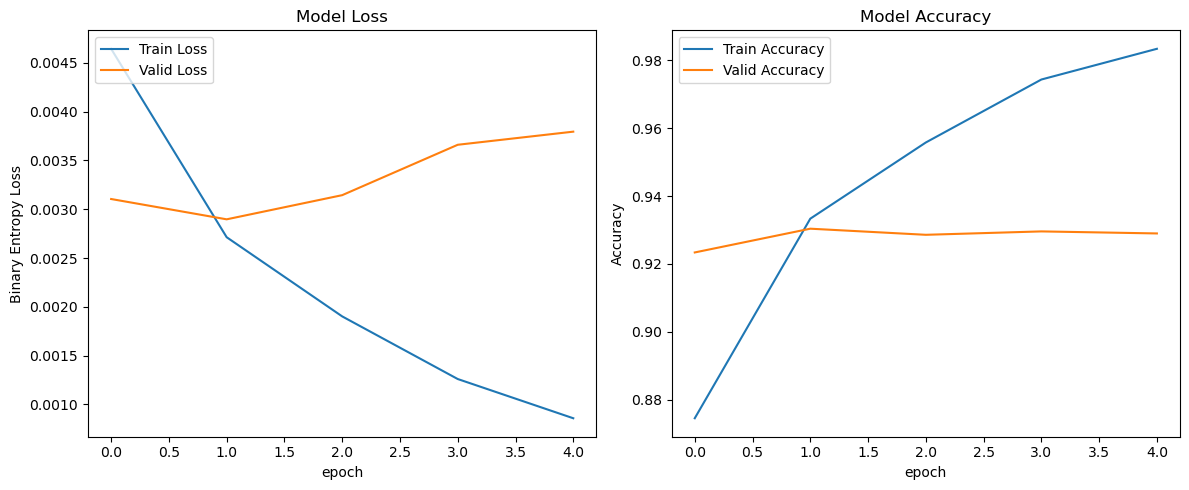

In [9]:
show_process(train_losses, train_accs, valid_losses, valid_accs, "Valid")

In [9]:
torch.cuda.empty_cache()

# Train and Test

In [8]:
model = torch.nn.DataParallel(module=BERTClassifier()).to(device_ids[0])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5, lr=5e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, last_epoch=-1)

n_epochs = 5
batch_size = 64
# using all training data
train_set = CustomTextDataset2(texts, labels, tokenizer)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

train_losses = []
train_accs = []

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device_ids[0])
        attention_mask = batch['attention_mask'].to(device_ids[0])
        labels = batch['labels'].to(device_ids[0])

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        _, predicted = torch.max(preds, dim=1)
        train_acc += torch.sum(predicted == labels).item()
    scheduler.step()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    print("epcoh [%d], train loss: [%.4f], train accuracy: [%.4f]" % (epoch, epoch_train_loss, epoch_train_acc))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/391 [00:00<?, ?it/s]

epcoh [1], train loss: [0.0051], train accuracy: [0.8584]


  0%|          | 0/391 [00:00<?, ?it/s]

epcoh [2], train loss: [0.0030], train accuracy: [0.9288]


  0%|          | 0/391 [00:00<?, ?it/s]

epcoh [3], train loss: [0.0025], train accuracy: [0.9435]


  0%|          | 0/391 [00:00<?, ?it/s]

epcoh [4], train loss: [0.0020], train accuracy: [0.9554]


  0%|          | 0/391 [00:00<?, ?it/s]

epcoh [5], train loss: [0.0017], train accuracy: [0.9647]


In [9]:
test_dataset = CustomTextDataset2(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_loss = 0.0
test_acc = 0.0
for batch in tqdm(test_loader):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device_ids[0])
        attention_mask = batch['attention_mask'].to(device_ids[0])
        labels = batch['labels'].to(device_ids[0])
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        _, predicted = torch.max(preds, dim=1)
        test_acc += torch.sum(predicted == labels).item()

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_acc / len(test_loader.dataset)
print("test loss: [%.4f], test accuracy: [%.4f]" % (test_loss, test_acc))

  0%|          | 0/391 [00:00<?, ?it/s]

test loss: [0.0029], test accuracy: [0.9354]


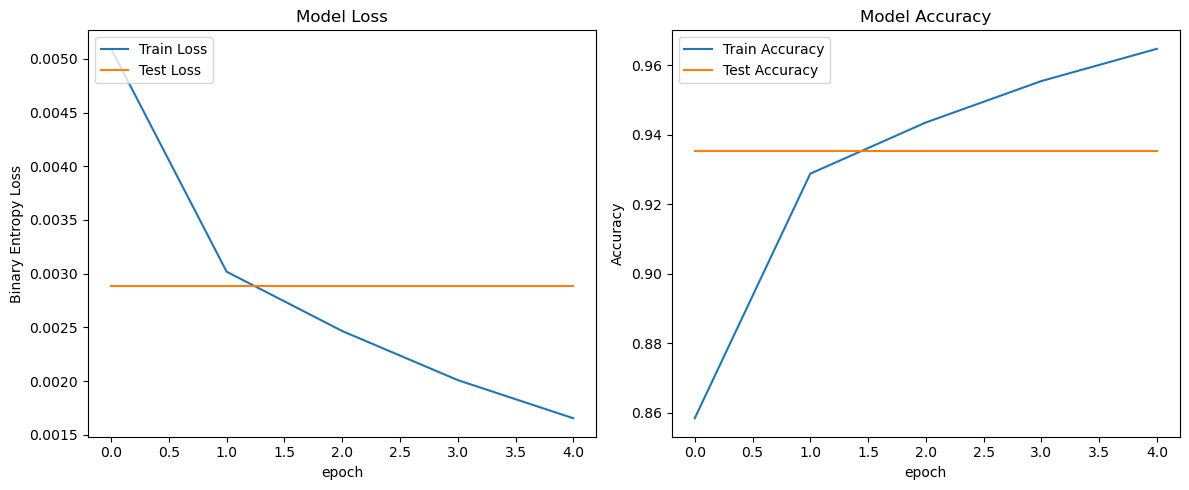

In [10]:
test_losses = [test_loss for _ in range(n_epochs)]
test_accs = [test_acc for _ in range(n_epochs)]
show_process(train_losses, train_accs, test_losses, test_accs, "Test") 